## Imports

In [200]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import pos_tag
from string import punctuation
import re
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from pandas_ml import ConfusionMatrix
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers import Bidirectional
from keras.layers import Embedding
# from keras.utils.np_utils import probas_to_classes
from sklearn import preprocessing
from keras.models import Sequential
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score,accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import rcParams
from random import shuffle
# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27

## Loading Data

In [201]:
def load_data_from_json(filename):
    with open(filename,'r') as f:
        return json.load(f)

In [202]:
master_dict = load_data_from_json('dataset/master.json')

In [203]:
master_dict

{'1': {'info': [{'aspects': "['Corporate/Appointment']",
    'sentiment_score': '-0.374',
    'snippets': "['set to step down']",
    'target': 'Royal Mail'}],
  'sentence': 'Royal Mail chairman Donald Brydon set to step down'},
 '7': {'info': [{'aspects': "['Corporate/Risks', 'Correct Aspect 3']",
    'sentiment_score': '-0.24',
    'snippets': "['Facing Tough Competition', 'Aspects 3 Snippet']",
    'target': 'AstraZeneca'}],
  'sentence': 'Stakes High for AstraZeneca Heart Drug Facing Tough Competition'},
 '8': {'info': [{'aspects': "['Corporate/Sales/Failed Contract Discussion']",
    'sentiment_score': '-0.161',
    'snippets': "['Crest loses a third of Morrisons milk contract']",
    'target': 'Morrisons'}],
  'sentence': 'UPDATE 1-Dairy Crest loses a third of Morrisons milk contract'},
 '22': {'info': [{'aspects': "['Corporate/Appointment/Executive Appointment']",
    'sentiment_score': '0.137',
    'snippets': '["hires Aviva\'s David Hillier for multi-asset team"]',
    'target

## Into Data

In [204]:
def extract_data_from_dict(master_dict):
    id_sentence = []
    sentence = []
    aspect = []
    target = []
    for key in master_dict.keys():
        id_sentence.append(int(key))
        sentence.append(master_dict[key]['sentence'])
        temp_target=[]
        temp_aspect = []
        for element in master_dict[key]['info']:
            temp_target.append(element['target'])
            temp_aspect.append(eval(element['aspects']))
        target.append(temp_target)
        aspect.append(temp_aspect)
    return id_sentence,sentence,aspect,target

In [205]:
id_sentence,sentence,aspect,target = extract_data_from_dict(master_dict)

In [206]:
len(id_sentence),len(sentence),len(aspect),len(target)

(1113, 1113, 1113, 1113)

In [207]:
#converting data into flat str
sentence_f = []
id_sentence_f = []
target_f = []
aspect_f = []
for a0 in zip(aspect,target,sentence,id_sentence):
    for a1 in zip(a0[0],a0[1]):
        for a2 in a1[0]:
            aspect_f.append(a2)
            target_f.append(a1[1])
            sentence_f.append(a0[2])
            id_sentence_f.append(a0[3])

In [208]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(1212, 1212, 1212, 1212)

In [209]:
for i,v in enumerate(aspect_f):
    if v == 'Correct Aspect 3' or v == 'under threat':
        aspect_f.pop(i)
        sentence_f.pop(i)
        id_sentence_f.pop(i)
        target_f.pop(i)

In [210]:
aspect_f_level1= []
aspect_f_level2=[]
for asp in aspect_f:
    try:
        aspect_f_level1.append(asp.split('/')[0])
        aspect_f_level2.append(asp.split('/')[1])
    except:
        print(asp)
# aspect_f

In [211]:
len(aspect_f_level2),len(aspect_f_level1)

(1210, 1210)

In [212]:
len(id_sentence_f),len(sentence_f),len(target_f),len(aspect_f)

(1210, 1210, 1210, 1210)

In [213]:
n_label_level_1 = len(set(aspect_f_level1))
n_label_level_2 = len(set(aspect_f_level2))
n_label_level_1,n_label_level_2

(4, 35)

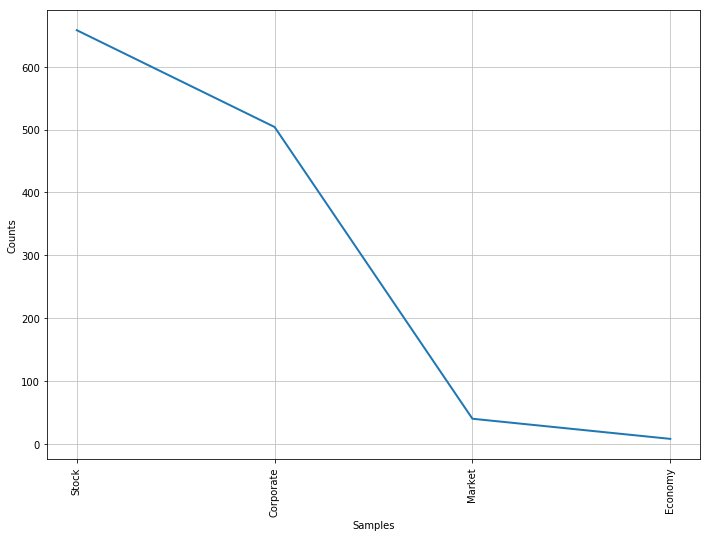

FreqDist({'Stock': 658, 'Corporate': 504, 'Market': 40, 'Economy': 8})


In [214]:
level1_freq = FreqDist(aspect_f_level1)
level1_freq.plot()
level1_freq.pprint()

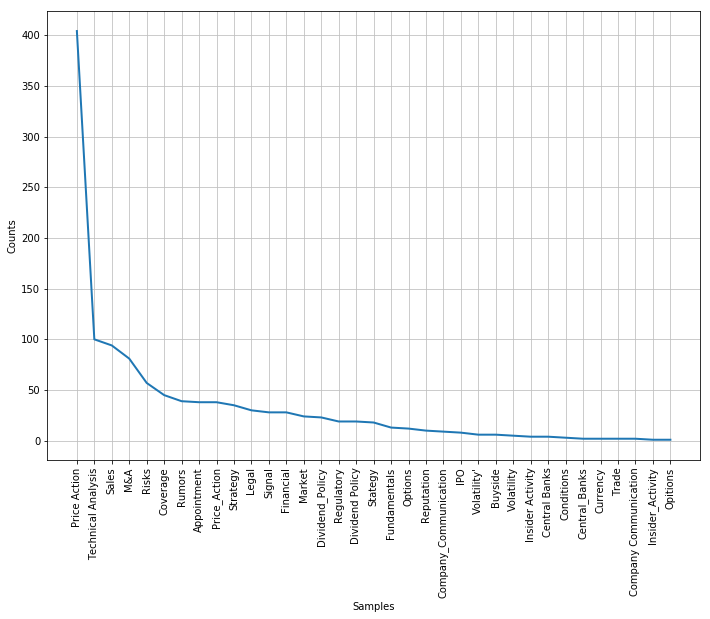

FreqDist({'Price Action': 404, 'Technical Analysis': 100, 'Sales': 94, 'M&A': 81, 'Risks': 57, 'Coverage': 45, 'Rumors': 39, 'Appointment': 38, 'Price_Action': 38, 'Strategy': 35, 'Legal': 30, 'Signal': 28, 'Financial': 28, 'Market': 24, 'Dividend_Policy': 23, 'Regulatory': 19, 'Dividend Policy': 19, 'Stategy': 18, 'Fundamentals': 13, 'Options': 12, 'Reputation': 10, 'Company_Communication': 9, 'IPO': 8, "Volatility'": 6, 'Buyside': 6, 'Volatility': 5, 'Insider Activity': 4, 'Central Banks': 4, 'Conditions': 3, 'Central_Banks': 2, 'Currency': 2, 'Trade': 2, 'Company Communication': 2, 'Insider_Activity': 1, 'Opitions': 1})


In [215]:
level2_freq = FreqDist(aspect_f_level2)
level2_freq.plot()
level2_freq.pprint(n_label_level_2)

In [258]:
#extracting least frequent level 2
n_least_class_to_extract = 25
least_freq_level2 = list()
for x in level2_freq.most_common()[-n_least_class_to_extract:]:
    least_freq_level2.append(x[0])
least_freq_level2

['Legal',
 'Signal',
 'Financial',
 'Market',
 'Dividend_Policy',
 'Regulatory',
 'Dividend Policy',
 'Stategy',
 'Fundamentals',
 'Options',
 'Reputation',
 'Company_Communication',
 'IPO',
 "Volatility'",
 'Buyside',
 'Volatility',
 'Insider Activity',
 'Central Banks',
 'Conditions',
 'Central_Banks',
 'Currency',
 'Trade',
 'Company Communication',
 'Insider_Activity',
 'Opitions']

In [217]:
def get_level_pairs(l1,l2):
    level_pair = dict()
    for pair in zip(l1,l2):
        if pair[1] in level_pair.keys():
            level_pair[pair[1]].append(pair[0])
        else:
            level_pair[pair[1]] = [pair[0]]
    for _ in level_pair.keys():
        level_pair[_] = list(set(level_pair[_]))
    return level_pair

In [218]:
L2_L1_pair = get_level_pairs(aspect_f_level1,aspect_f_level2)
L1_L2_pair = get_level_pairs(aspect_f_level2,aspect_f_level1)

In [219]:
L1_L2_pair

{'Corporate': ['Company Communication',
  'Risks',
  'Dividend_Policy',
  'Legal',
  'Technical Analysis',
  'Regulatory',
  'Rumors',
  'Sales',
  'Strategy',
  'Company_Communication',
  'Financial',
  'M&A',
  'Stategy',
  'Dividend Policy',
  'Appointment',
  'Reputation'],
 'Economy': ['Central Banks', 'Central_Banks', 'Trade'],
 'Market': ["Volatility'", 'Currency', 'Market', 'Volatility', 'Conditions'],
 'Stock': ['Insider Activity',
  'Opitions',
  'Signal',
  'Price_Action',
  'Insider_Activity',
  'Options',
  'IPO',
  'Fundamentals',
  'Buyside',
  'Coverage',
  'Price Action',
  'Technical Analysis']}

In [220]:
L2_L1_pair

{'Appointment': ['Corporate'],
 'Buyside': ['Stock'],
 'Central Banks': ['Economy'],
 'Central_Banks': ['Economy'],
 'Company Communication': ['Corporate'],
 'Company_Communication': ['Corporate'],
 'Conditions': ['Market'],
 'Coverage': ['Stock'],
 'Currency': ['Market'],
 'Dividend Policy': ['Corporate'],
 'Dividend_Policy': ['Corporate'],
 'Financial': ['Corporate'],
 'Fundamentals': ['Stock'],
 'IPO': ['Stock'],
 'Insider Activity': ['Stock'],
 'Insider_Activity': ['Stock'],
 'Legal': ['Corporate'],
 'M&A': ['Corporate'],
 'Market': ['Market'],
 'Opitions': ['Stock'],
 'Options': ['Stock'],
 'Price Action': ['Stock'],
 'Price_Action': ['Stock'],
 'Regulatory': ['Corporate'],
 'Reputation': ['Corporate'],
 'Risks': ['Corporate'],
 'Rumors': ['Corporate'],
 'Sales': ['Corporate'],
 'Signal': ['Stock'],
 'Stategy': ['Corporate'],
 'Strategy': ['Corporate'],
 'Technical Analysis': ['Corporate', 'Stock'],
 'Trade': ['Economy'],
 'Volatility': ['Market'],
 "Volatility'": ['Market']}

In [221]:
C_Stock = 0
C_Corporate = 0
for pair in zip(aspect_f_level1,aspect_f_level2):
    if pair[1] == 'Technical Analysis':
        if pair[0] == 'Stock':
            C_Stock+=1
        else:
            C_Corporate+=1
print('C_Stock == ',C_Stock)
print('C_Corporate ==',C_Corporate)

C_Stock ==  98
C_Corporate == 2


In [222]:
#checking pos tags of target and there freq
target_tags_freq = dict()
for s in sentence_f:
    text = word_tokenize(s)
    for pair in pos_tag(text):
        if pair[0] in target_f:
            if pair[1] in target_tags_freq.keys():
                target_tags_freq[pair[1]]+=1
            else:
                target_tags_freq[pair[1]] =1
target_tags_freq

{'$': 2,
 'CD': 35,
 'IN': 2,
 'JJ': 14,
 'NN': 26,
 'NNP': 1278,
 'NNS': 21,
 'PDT': 3,
 'PRP': 1,
 'RB': 2,
 'VB': 6,
 'VBP': 1,
 'VBZ': 1}

In [223]:
#number of words having same pos tags but not target
count = 0
for s in sentence_f:
    text = word_tokenize(s)
    for pair in pos_tag(text):
        if pair[1] in target_tags_freq.keys() and pair[0] not in target_f:
            count+=1
count

12092

## pre-processing data

In [224]:
def clean_sentence(sentence):
    #remove multiple repeat non num-aplha char !!!!!!!!!-->!
    sentence = re.sub(r'(\W)\1{2,}', r'\1', sentence) 
    #removes alpha char repeating more than twice aaaa->aa
    sentence = re.sub(r'(\w)\1{2,}', r'\1\1', sentence)
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"(?:\@|https?\://)\S+", "", sentence)
    #removing stock names to see if it helps
    sentence = re.sub(r"(?:\$|https?\://)\S+", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
#     tokens = [word for word in tokens if word.isalpha()]
#no removing non alpha words to keep stock names($ZSL)
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [225]:
sentenceX = [clean_sentence(x) for x in sentence_f]

In [226]:
# sentenceX

In [227]:
Level_1Y = aspect_f_level1
Level_2Y = aspect_f_level2

In [259]:
#clubing least n freq Level 1class together into Other
Level_2_lables_clubed = list()
for aspect in Level_2Y:
    if aspect in least_freq_level2:
        Level_2_lables_clubed.append('Other')
    else:
        Level_2_lables_clubed.append(aspect)
len(Level_2_lables_clubed),len(Level_2Y)

(1210, 1210)

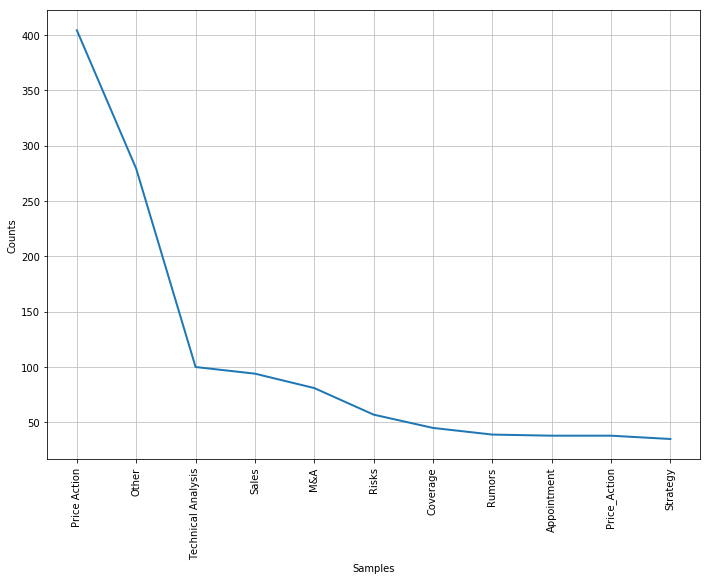

FreqDist({'Price Action': 404, 'Other': 279, 'Technical Analysis': 100, 'Sales': 94, 'M&A': 81, 'Risks': 57, 'Coverage': 45, 'Rumors': 39, 'Appointment': 38, 'Price_Action': 38, ...})


In [260]:
level2_clubed_freq = FreqDist(Level_2_lables_clubed)
level2_clubed_freq.plot()
level2_clubed_freq.pprint()

In [230]:
lengths = [len(s.split()) for s in sentenceX]

max len =  21


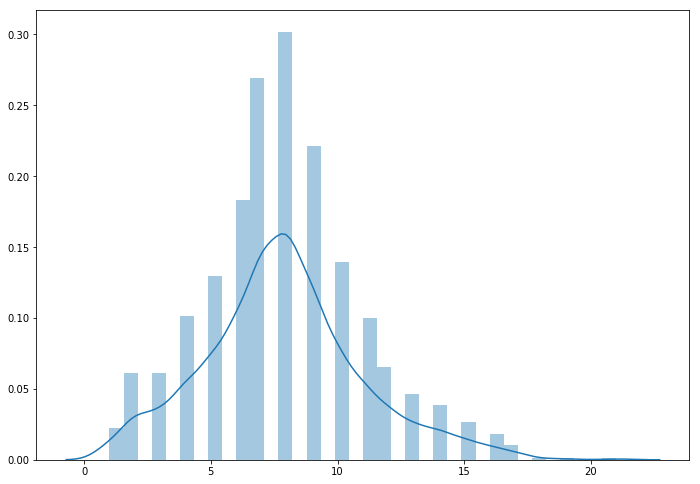

In [231]:
print('max len = ',max(lengths))
sns.distplot(lengths)

In [232]:
max_length  = 12

## Model

In [283]:
tranLines = sentenceX
trainLabels = aspect_f_level2
# trainLabels = Level_2_lables_clubed

In [284]:
no_of_classes = len(set(trainLabels))
no_of_classes

35

In [285]:
# trainX,testX = tranLines[:int(len(tranLines)*0.9)],tranLines[int(len(tranLines)*0.9):]
# trainY,testY = trainLabels[:int(len(trainLabels)*0.9)],trainLabels[int(len(trainLabels)*0.9):]
trainX, testX, trainY, testY = train_test_split(tranLines, trainLabels, test_size=0.1)

In [286]:
print(len(trainX),len(trainY))
print(len(testX),len(testY))

1089 1089
121 121


In [287]:
# fit a tokenizer
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [288]:
# encode a list of lines
def encode_text(tokenizer, lines, length):
    # integer encode
    encoded = tokenizer.texts_to_sequences(lines)
    # pad encoded sequences
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [289]:
# create tokenizer
tokenizer = create_tokenizer(trainX)
# calculate max document length
# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_length)
print('Vocabulary size: %d' % vocab_size)
# encode data
trainX = encode_text(tokenizer, trainX, max_length)
testX = encode_text(tokenizer, testX, max_length)
print(trainX.shape,testX.shape)

Max document length: 12
Vocabulary size: 3178
(1089, 12) (121, 12)


In [290]:
def convert_lables(trainY,testY):
    le = preprocessing.LabelEncoder()
    le.fit(trainY+testY)
    temp1 = le.transform(trainY)
    temp2 = le.transform(testY)
    return to_categorical(temp1,no_of_classes),to_categorical(temp2,no_of_classes),le.classes_

In [291]:
trainY,testY,lable_encoding = convert_lables(trainY,testY)

In [292]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [293]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [294]:
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)

In [295]:
def defina_model():
    lstm_out = 400
    model = Sequential()
    model.add(Embedding(vocab_size,300,weights=[embedding_matrix_word2vec],input_length=max_length,trainable = False))
    model.add(Bidirectional(LSTM(lstm_out, recurrent_dropout=0.2)))
    model.add(Dense(400,activation='relu'))
    model.add(Dense(200,activation='relu'))
    model.add(Dense(no_of_classes,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    print(model.summary())
    return model

In [296]:
model = defina_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 12, 300)           953400    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 800)               2243200   
_________________________________________________________________
dense_26 (Dense)             (None, 400)               320400    
_________________________________________________________________
dense_27 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_28 (Dense)             (None, 35)                7035      
Total params: 3,604,235
Trainable params: 2,650,835
Non-trainable params: 953,400
_________________________________________________________________
None


In [297]:
history_object = model.fit(trainX, trainY, epochs=20,batch_size=32)

Epoch 1/20
1089/1089 [==============================] - 9s 9ms/step - loss: 2.6187 - acc: 0.3398
Epoch 2/20
1089/1089 [==============================] - 7s 6ms/step - loss: 1.8552 - acc: 0.4913
Epoch 3/20
1089/1089 [==============================] - 7s 6ms/step - loss: 1.4595 - acc: 0.6088
Epoch 4/20
1089/1089 [==============================] - 7s 6ms/step - loss: 1.3456 - acc: 0.6217
Epoch 5/20
1089/1089 [==============================] - 7s 6ms/step - loss: 1.0727 - acc: 0.6786A
Epoch 6/20
1089/1089 [==============================] - 7s 6ms/step - loss: 0.9375 - acc: 0.7208
Epoch 7/20
1089/1089 [==============================] - 7s 6ms/step - loss: 1.0452 - acc: 0.6896
Epoch 8/20
1089/1089 [==============================] - 8s 7ms/step - loss: 0.6276 - acc: 0.8136
Epoch 9/20
1089/1089 [==============================] - 7s 7ms/step - loss: 0.5426 - acc: 0.8421
Epoch 10/20
1089/1089 [==============================] - 8s 7ms/step - loss: 0.4552 - acc: 0.8696
Epoch 11/20
1089/1089 [=====

In [298]:
model.evaluate(testX,testY)

121/121 [==============================] - 1s 8ms/step


[2.4530734050372414, 0.6528925590278688]

In [299]:
pred = model.predict(testX)

In [300]:
test_label_act = [lable_encoding[x.argmax()] for x in testY]
test_label_pred = [lable_encoding[x.argmax()] for x in pred]

In [301]:
cnf_matrix = confusion_matrix(test_label_act, test_label_pred)
cnf_matrix

array([[ 6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  2,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 

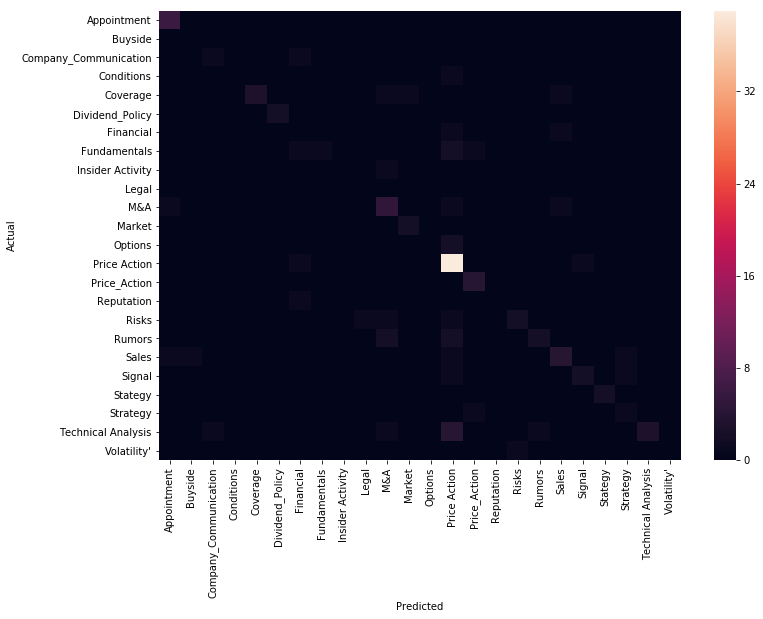

In [302]:
ConfusionMatrix(test_label_act, test_label_pred).plot(backend='seaborn')

In [303]:
#get metric scores
def print_metric(yacc,ypred,avg_type):
    print('---------------------avg type = {0}---------------------------------------------'.format(avg_type))
    print('F1 score == ', f1_score(yacc,ypred,average=avg_type))
    print('precision score == ', precision_score(yacc,ypred,average=avg_type))
    print('recall score == ', recall_score(yacc,ypred,average=avg_type))
    print('accuracy score == ', accuracy_score(yacc,ypred))

In [305]:
print_metric(test_label_act,test_label_pred,None)
print_metric(test_label_act,test_label_pred,'micro')
print_metric(test_label_act,test_label_pred,'macro')
print_metric(test_label_act,test_label_pred,'weighted')

---------------------avg type = None---------------------------------------------
F1 score ==  [0.85714286 0.         0.5        0.         0.66666667 1.
 0.         0.33333333 0.         0.         0.52631579 0.8
 0.         0.8125     0.8        0.         0.5        0.44444444
 0.53333333 0.57142857 1.         0.4        0.46153846 0.        ]
precision score ==  [0.75       0.         0.5        0.         1.         1.
 0.         1.         0.         0.         0.45454545 0.66666667
 0.         0.70909091 0.66666667 0.         0.66666667 0.66666667
 0.57142857 0.66666667 1.         0.33333333 1.         0.        ]
recall score ==  [1.         0.         0.5        0.         0.5        1.
 0.         0.2        0.         0.         0.625      1.
 0.         0.95121951 1.         0.         0.4        0.33333333
 0.5        0.5        1.         0.5        0.3        0.        ]
accuracy score ==  0.6528925619834711
---------------------avg type = micro-------------------------

/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/hitkul/anaconda3/envs/ps3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [117]:
test_label_act

['Technical Analysis',
 'IPO',
 'Sales',
 'Dividend_Policy',
 'Fundamentals',
 'Appointment',
 'Reputation',
 'Dividend_Policy',
 'Strategy',
 'Sales',
 'Signal',
 'Sales',
 'Price Action',
 'Sales',
 "Volatility'",
 'Dividend_Policy',
 'M&A',
 'Sales',
 'M&A',
 'Sales',
 'Regulatory',
 'Rumors',
 'Rumors',
 'Signal',
 'M&A',
 'M&A',
 'Sales',
 'Appointment',
 'Sales',
 'Price_Action',
 'Risks',
 'Market',
 'M&A',
 'Rumors',
 'Appointment',
 'Signal',
 'M&A',
 'Dividend Policy',
 'Dividend_Policy',
 'Appointment',
 'Central_Banks',
 'Sales',
 'Fundamentals',
 'Risks',
 'Market',
 'Strategy',
 'Dividend_Policy',
 'Reputation',
 'Signal',
 'Risks',
 'Appointment',
 'Dividend_Policy',
 'Legal',
 'Dividend Policy']